In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['movie_data']


In [2]:
import os
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [3]:
reviews_train = []
for line in open('../input/movie_data/movie_data/full_train.txt', 'r'):
    
    reviews_train.append(line.strip())
    
reviews_test = []
for line in open('../input/movie_data/movie_data/full_test.txt', 'r'):
    
    reviews_test.append(line.strip())
    
target = [1 if i < 12500 else 0 for i in range(25000)]

In [4]:
REPLACE_NO_SPACE = re.compile("(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
NO_SPACE = ""
SPACE = " "

def preprocess_reviews(reviews):
    
    reviews = [REPLACE_NO_SPACE.sub(NO_SPACE, line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(SPACE, line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(reviews_train)
reviews_test_clean = preprocess_reviews(reviews_test)

In [5]:
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')

def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words

In [6]:
no_stop_words_train = remove_stop_words(reviews_train_clean)
no_stop_words_test = remove_stop_words(reviews_test_clean)

In [12]:
all_text = ' '.join([text for text in no_stop_words_train])
print('Number of words in all_text:', len(all_text))

Number of words in all_text: 20950572


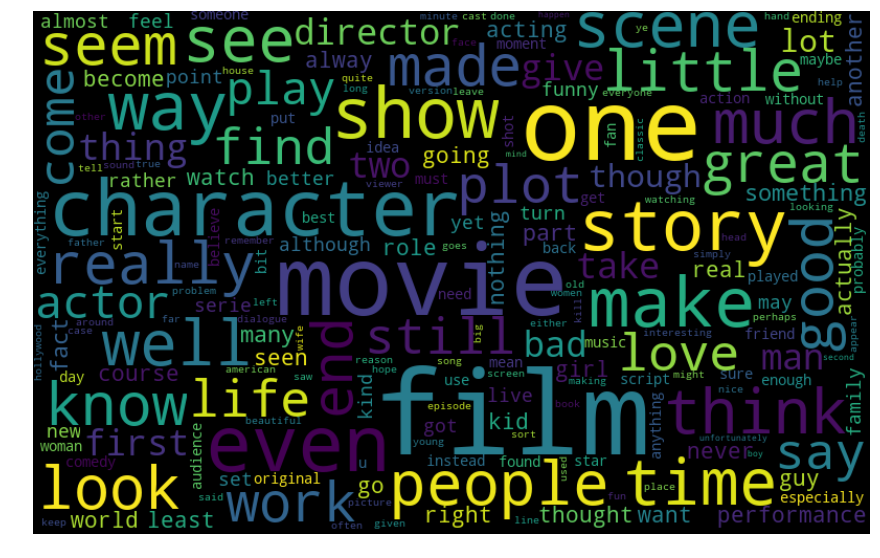

In [13]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
from keras.preprocessing.text import Tokenizer

vocab_size = 5000
max_words = 500
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(no_stop_words_train)

X_train = tokenizer.texts_to_sequences(no_stop_words_train)
X_test = tokenizer.texts_to_sequences(no_stop_words_test)

In [ ]:
#stopword_vectorizer = CountVectorizer()
#stopword_vectorizer.fit(no_stop_words_train)
#print("Size of dictionary: ", len(stopword_vectorizer.get_feature_names()))
#print("Words in dictionary: ", stopword_vectorizer.get_feature_names())

#X_train = stopword_vectorizer.transform(no_stop_words_train).toarray()
#X_test = stopword_vectorizer.transform(no_stop_words_test).toarray()

In [ ]:
from keras.preprocessing import sequence
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, target, train_size = 0.85)

In [ ]:
X_train.shape

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPool1D
from keras.preprocessing import sequence
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.000001, verbose=1)
earlt_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

**Model 1**

In [ ]:
model = Sequential()
#model.add(Embedding(len(stopword_vectorizer.get_feature_names()), 32, input_length=max_words))
model.add(Embedding(vocab_size, 32, input_length=max_words))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=128, verbose=1, callbacks=[reduce_lr, earlt_stopper]).history

In [ ]:
plt.plot(history['acc'], linewidth=2, label='Train')
plt.plot(history['val_acc'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

**Model 2**

In [ ]:
embedding_size = 32
model=Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_words))
model.add(Dropout(0.2))
model.add(Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool1D(pool_size = 2))
model.add(LSTM(100))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, verbose=1, callbacks=[reduce_lr, earlt_stopper]).history

In [ ]:
plt.plot(history['acc'], linewidth=2, label='Train')
plt.plot(history['val_acc'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

**Model 3**

In [ ]:
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=max_words))
model.add(LSTM(100, activation = 'tanh', recurrent_activation='hard_sigmoid', dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=128, verbose=1, callbacks=[reduce_lr, earlt_stopper]).history

In [ ]:
plt.plot(history['acc'], linewidth=2, label='Train')
plt.plot(history['val_acc'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()